In [1]:
import time

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pyensembl import EnsemblRelease
from sklearn.metrics import root_mean_squared_error

from script.data_loading import find_path, make_path, study_info
from script.junctions import get_junctions
from script.misc import savefig_pdf
from script.predictions import SpliceSitePredictor, spliceai, pangolin
from script.sequences import Annotator

In [2]:
ensembl = EnsemblRelease(111)
brca1 = ensembl.gene_by_id('ENSG00000012048')

In [3]:
study_info.head()

,splice,expression,wgs_brass,wgs_pindel,wgs_caveman,total_size
case_id,,,,,,
c1442467-d618-435f-8792-b1a18f696f1a,65c868ba-94ed-43f2-bfd1-814979ee9486.rna_seq.s...,65c868ba-94ed-43f2-bfd1-814979ee9486.rna_seq.a...,c2603e63-fa7d-4ebc-936e-bed52cc932e4.wgs.BRASS...,c2603e63-fa7d-4ebc-936e-bed52cc932e4.wgs.sange...,c2603e63-fa7d-4ebc-936e-bed52cc932e4.wgs.CaVEM...,95698959
9435447e-d65f-408b-863b-6576b1d652dd,7c9a2493-5667-48ec-8998-81e13722b4ab.rna_seq.s...,7c9a2493-5667-48ec-8998-81e13722b4ab.rna_seq.a...,fb4526f0-ee99-46aa-a0df-f125a460b0a3.wgs.BRASS...,fb4526f0-ee99-46aa-a0df-f125a460b0a3.wgs.sange...,fb4526f0-ee99-46aa-a0df-f125a460b0a3.wgs.CaVEM...,87714708
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3,1a3dcc95-64bf-4886-9807-9511b24f30af.rna_seq.s...,1a3dcc95-64bf-4886-9807-9511b24f30af.rna_seq.a...,a30866df-bce8-46ff-8918-bfa7956fdfbc.wgs.BRASS...,a30866df-bce8-46ff-8918-bfa7956fdfbc.wgs.sange...,a30866df-bce8-46ff-8918-bfa7956fdfbc.wgs.CaVEM...,96440606
0adf59c6-581a-475d-a2f4-40aa40060b5b,9d025af7-ba40-4329-9308-d039aaad900b.rna_seq.s...,9d025af7-ba40-4329-9308-d039aaad900b.rna_seq.a...,aa368df9-0840-4619-86d3-46bf56179fee.wgs.BRASS...,aa368df9-0840-4619-86d3-46bf56179fee.wgs.sange...,aa368df9-0840-4619-86d3-46bf56179fee.wgs.CaVEM...,95034341
0045349c-69d9-4306-a403-c9c1fa836644,36125e17-48fd-4eea-874c-ed2e2e218402.rna_seq.s...,36125e17-48fd-4eea-874c-ed2e2e218402.rna_seq.a...,4598a0fe-4bbf-413d-8f9b-db38d4f213d5.wgs.BRASS...,4598a0fe-4bbf-413d-8f9b-db38d4f213d5.wgs.sange...,4598a0fe-4bbf-413d-8f9b-db38d4f213d5.wgs.CaVEM...,90039272


## Find and aggregate absolute junction use

In [4]:
junctions_path = 'junctions.pkl'
try:
    junctions = pd.read_pickle(find_path(junctions_path))
except KeyError:
    junctions = pd.DataFrame()
    for case_id in study_info.index:
        new_j = get_junctions(case_id, brca1).T
        if junctions.empty:
            junctions = new_j
        else:
            junctions = pd.concat([junctions, new_j], ignore_index=True)
    junctions = junctions.reindex(sorted(junctions.columns), axis=1).fillna(0)
    junctions.index = study_info.index
    junctions.to_pickle(make_path(junctions_path))

junctions

intron_donor                         43044745 43045803                    \
intron_acceptor                      43044774 43047642 43049120 43051062   
case_id                                                                    
c1442467-d618-435f-8792-b1a18f696f1a      0.0      8.0      0.0      0.0   
9435447e-d65f-408b-863b-6576b1d652dd      0.0      9.0      0.0      0.0   
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3      0.0      9.0      0.0      0.0   
0adf59c6-581a-475d-a2f4-40aa40060b5b      0.0     16.0      0.0      0.0   
0045349c-69d9-4306-a403-c9c1fa836644      0.0     15.0      0.0      0.0   
...                                       ...      ...      ...      ...   
97b5f490-1cd9-4833-b903-5f4c6e45670d      0.0     16.0      0.0      0.0   
991e1427-3c01-423d-abfd-4584302ca72c      0.0      9.0      0.0      0.0   
993103b1-e5a1-4c33-8629-be53ebc41d64      0.0      4.0      0.0      0.0   
b8b6cebc-26dc-43ae-a94a-20da6018f7ae      0.0     17.0      0.0      0.0   
0b23b5fe-6c7e-4297-bc55-f93fcb830ac4      0.0     49.0      0.0      0.0   

intron_donor                         43047704          43049195           \
intron_acceptor                      43049120 43051062 43049781 43050061   
case_id                                                                    
c1442467-d618-435f-8792-b1a18f696f1a      9.0      0.0      0.0      0.0   
9435447e-d65f-408b-863b-6576b1d652dd      4.0      0.0      0.0      0.0   
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3     18.0      1.0      0.0      1.0   
0adf59c6-581a-475d-a2f4-40aa40060b5b     14.0      0.0      0.0      0.0   
0045349c-69d9-4306-a403-c9c1fa836644     23.0      0.0      0.0      0.0   
...                                       ...      ...      ...      ...   
97b5f490-1cd9-4833-b903-5f4c6e45670d     28.0      0.0      0.0      0.0   
991e1427-3c01-423d-abfd-4584302ca72c     20.0      0.0      0.0      0.0   
993103b1-e5a1-4c33-8629-be53ebc41d64      5.0      1.0      0.0      0.0   
b8b6cebc-26dc-43ae-a94a-20da6018f7ae     10.0      0.0      0.0      0.0   
0b23b5fe-6c7e-4297-bc55-f93fcb830ac4     63.0      0.0      0.0      0.0   

intron_donor                                            ... 43167251           \
intron_acceptor                      43051062 43057051  ... 43167733 43169756   
case_id                                                 ...                     
c1442467-d618-435f-8792-b1a18f696f1a     15.0      0.0  ...      0.0      0.0   
9435447e-d65f-408b-863b-6576b1d652dd      0.0      0.0  ...      0.0      0.0   
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3     20.0      0.0  ...      0.0      0.0   
0adf59c6-581a-475d-a2f4-40aa40060b5b     21.0      0.0  ...      0.0      0.0   
0045349c-69d9-4306-a403-c9c1fa836644     11.0      0.0  ...      0.0      0.0   
...                                       ...      ...  ...      ...      ...   
97b5f490-1cd9-4833-b903-5f4c6e45670d     14.0      0.0  ...      0.0      0.0   
991e1427-3c01-423d-abfd-4584302ca72c     13.0      0.0  ...      0.0      0.0   
993103b1-e5a1-4c33-8629-be53ebc41d64     12.0      0.0  ...      0.0      0.0   
b8b6cebc-26dc-43ae-a94a-20da6018f7ae     12.0      2.0  ...      0.0      0.0   
0b23b5fe-6c7e-4297-bc55-f93fcb830ac4     62.0      0.0  ...      0.0      0.0   

intron_donor                                  43167263          43167850  \
intron_acceptor                      43170125 43169756 43170125 43168169   
case_id                                                                    
c1442467-d618-435f-8792-b1a18f696f1a      0.0      0.0      0.0      0.0   
9435447e-d65f-408b-863b-6576b1d652dd      0.0      0.0      0.0      0.0   
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3      3.0      0.0      2.0      0.0   
0adf59c6-581a-475d-a2f4-40aa40060b5b      5.0      3.0      0.0      0.0   
0045349c-69d9-4306-a403-c9c1fa836644      1.0      0.0      2.0      0.0   
...                                       ...      ...      ...      ...   
97b5f490-1cd9-4833-b903-5f4c6e45670d      0.0      

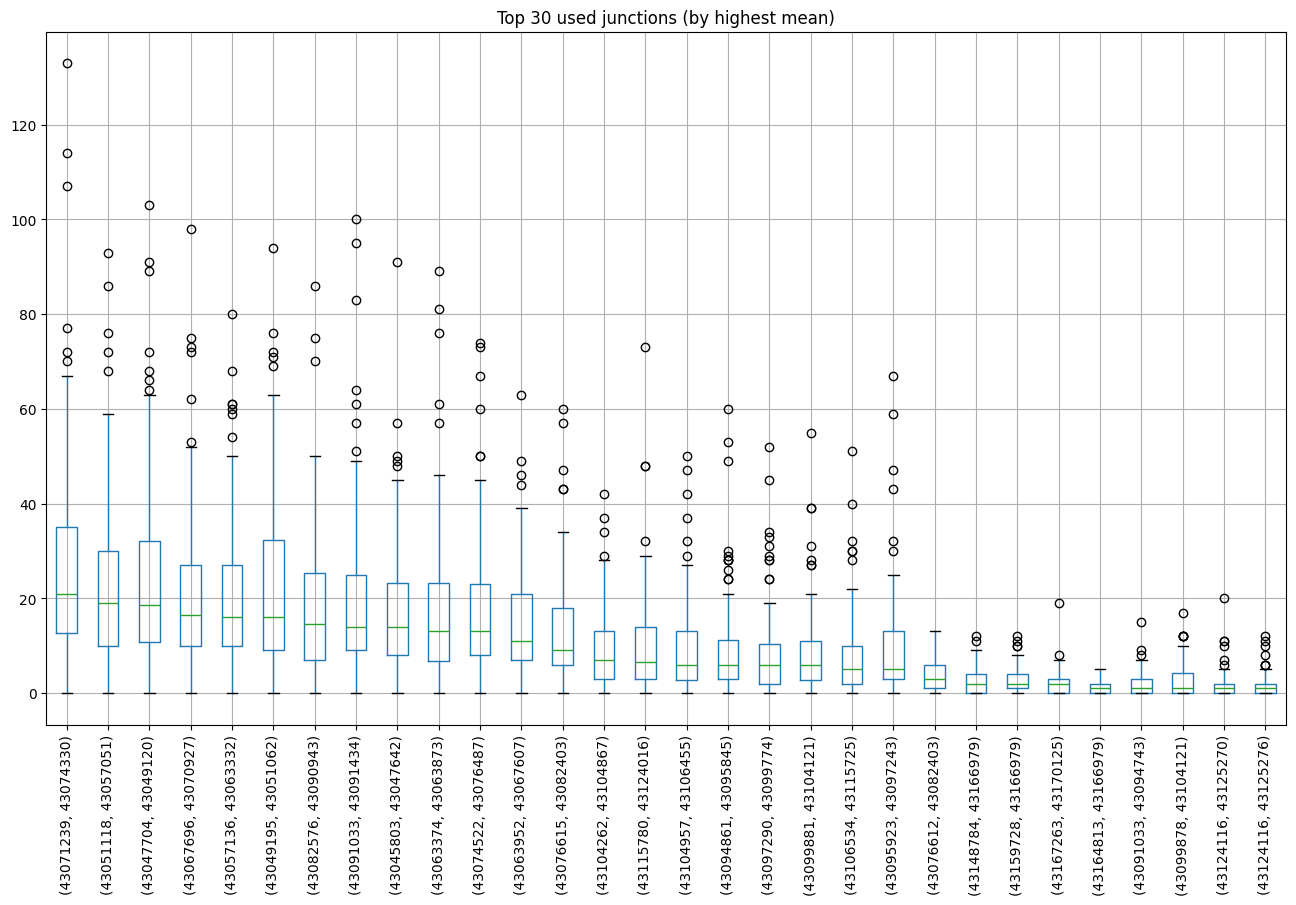

In [5]:
top_n = 30
junctions\
    .reindex(junctions.median().sort_values(ascending=False).index, axis=1)\
    .iloc[:,:top_n]\
    .boxplot(figsize=(16, 9), rot=90)
plt.title(f'Top {top_n} used junctions (by highest mean)')
plt.show()

## Aggregate donor/acceptor probabilities

In [6]:
donor_probs = junctions.T.groupby(level=0).sum().T
acceptor_probs = junctions.T.groupby(level=1).sum().T
# normalize by max usage
# we consider this the "next best" alternative since we can't use actual read
# counts of the genes because those also include exon-only reads that have
# occured
donor_probs = donor_probs.div(donor_probs.max(axis=1), axis=0)
# exact donor base pair is interpreted differently by GDC
donor_probs.columns -= 2
acceptor_probs = acceptor_probs.div(acceptor_probs.max(axis=1), axis=0)

# splice sites can't be donor and acceptor at the same time
faulty_splice_sites = set(donor_probs.columns).intersection(set(acceptor_probs.columns))
if len(faulty_splice_sites) > 0:
    print(f'Invalid data, the following sites are both donor and acceptor: {faulty_splice_sites}')

# merge donor and acceptor
splice_probs = pd.concat([donor_probs, acceptor_probs], axis=1)
splice_probs = splice_probs.reindex(sorted(splice_probs.columns), axis=1)
splice_probs

,43044743,43044774,43045801,43047642,43047702,43049120,43049193,43049781,43049891,43049959,...,43167249,43167261,43167733,43167848,43168169,43168267,43169166,43169756,43170125,43170146
case_id,,,,,,,,,,,,,,,,,,,,,
c1442467-d618-435f-8792-b1a18f696f1a,0.0,0.0,0.444444,0.444444,0.500000,0.500000,0.833333,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.055556,0.000000,0.0,0.0,0.000000,0.222222,0.0
9435447e-d65f-408b-863b-6576b1d652dd,0.0,0.0,0.500000,0.500000,0.222222,0.222222,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3,0.0,0.0,0.346154,0.346154,0.730769,0.692308,0.807692,0.0,0.0,0.0,...,0.115385,0.076923,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.500000,0.0
0adf59c6-581a-475d-a2f4-40aa40060b5b,0.0,0.0,0.761905,0.761905,0.666667,0.666667,1.000000,0.0,0.0,0.0,...,0.238095,0.142857,0.0,0.000000,0.000000,0.0,0.0,0.142857,0.476190,0.0
0045349c-69d9-4306-a403-c9c1fa836644,0.0,0.0,0.625000,0.625000,0.958333,0.958333,0.458333,0.0,0.0,0.0,...,0.041667,0.083333,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.166667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97b5f490-1cd9-4833-b903-5f4c6e45670d,0.0,0.0,0.571429,0.571429,1.000000,1.000000,0.500000,0.0,0.0,0.0,...,0.000000,0.035714,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.035714,0.0
991e1427-3c01-423d-abfd-4584302ca72c,0.0,0.0,0.450000,0.450000,1.000000,1.000000,0.650000,0.0,0.0,0.0,...,0.050000,0.100000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.350000,0.0
993103b1-e5a1-4c33-8629-be53ebc41d64,0.0,0.0,0.250000,0.250000,0.375000,0.312500,0.750000,0.0,0.0,0.0,...,0.062500,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.125000,0.0


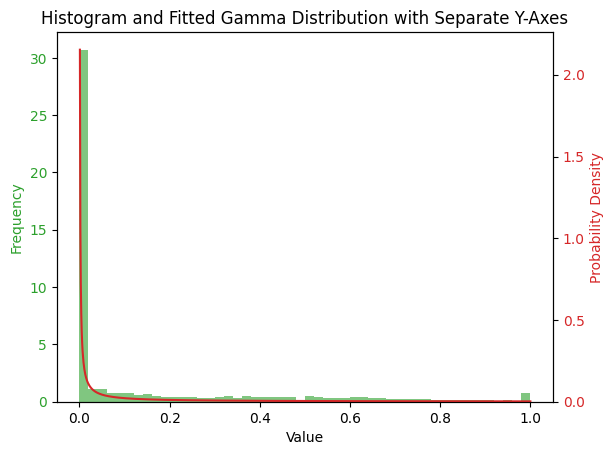

In [7]:
from scipy.stats import gamma

flat_probs = splice_probs.values.ravel()
alpha, loc, beta = gamma.fit(flat_probs + np.nextafter(0, 1), floc=0)
x = np.linspace(0, 1, 1000)
pdf_fitted = gamma.pdf(x, alpha, loc, beta)

# Plot the histogram of the data
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency', color=color)
ax1.hist(flat_probs, bins=50, density=True, alpha=0.6, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis to plot the fitted Gamma distribution
ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Probability Density', color=color)
ax2.plot(x, pdf_fitted, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Ensure both y-axes have the same zero alignment
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

# Add title
plt.title('Histogram and Fitted Gamma Distribution with Separate Y-Axes')

# Show plot
plt.show()

## Compare predictions against experimental data

In [8]:
# predictor to use
predictor: SpliceSitePredictor = pangolin
# VCF algorithm to base genome reconstruction on (wgs_pindel or wgs_caveman)
variants: str = 'wgs_pindel'
# use existing results if they exist
use_cached = True
# save new results if they had to be computed
save_new = True

In [9]:
def get_probabilities(case_id: str):
    result_path = f'{predictor.name()}.{variants}.{case_id}.pkl'
    if use_cached:
        try:
            return pd.read_pickle(find_path(result_path))
        except KeyError:
            pass
    
    ann = Annotator(find_path(study_info.loc[case_id][variants]))
    # predicted splice probability and index alignment
    pps_raw, var_idx = (pd.Series(result) for result in predictor.predict(ann, brca1))
    # normalize by max use analogously to experimental data
    pps_raw /= pps_raw.max()

    # new Series for aligned predictions with max aggregation
    # (we use vanilla dicts for their faster indexing and then convert to series later)
    pps = dict[int, float]()
    for r, indices in enumerate(var_idx):
        for idx in indices:
            pps[idx] = max(pps[idx], pps_raw.loc[r]) if idx in pps else pps_raw.loc[r]
    pps = pd.Series(pps)

    # experimental ("true") splice probabilities
    brca1_range = range(brca1.start, brca1.end + 1)
    tps = splice_probs.loc[case_id].reindex(brca1_range, fill_value=0)

    df = pd.concat([tps, pps], axis=1, keys=['true', 'predicted'])
    # NA predictions mean that the corresponding position was deleted by the variant, i.e. we set them to 0
    df['predicted'] = df['predicted'].fillna(0)

    df = df.loc[brca1_range]
    if save_new:
        df.to_pickle(make_path('evaluation', result_path))
    return df

In [10]:
start = time.time()

results = pd.Series()
# root mean squared errors
rmses = pd.Series()

for i, case_id in enumerate(study_info.index):
    print(f'CASE {i+1:3d}/{len(study_info)}: {case_id}')
    try:
        df = get_probabilities(case_id)
        results.loc[case_id] = df
        rmses.loc[case_id] = root_mean_squared_error(df['true'], df['predicted'])
    except Exception as e:
        print('  ERROR')
        print(e)
        print(f'  Skipping case {case_id}')

end = time.time()
print(f'Total time: {end - start}s')

CASE   1/100: c1442467-d618-435f-8792-b1a18f696f1a
CASE   2/100: 9435447e-d65f-408b-863b-6576b1d652dd
CASE   3/100: 0bf6e772-1aa1-4f54-9a50-c1414e2f22f3
CASE   4/100: 0adf59c6-581a-475d-a2f4-40aa40060b5b
CASE   5/100: 0045349c-69d9-4306-a403-c9c1fa836644
CASE   6/100: 427d0648-3f77-4ffc-b52c-89855426d647
  ERROR
'934b8c4b-7f7a-4001-9f21-c642216b5cbc.wgs.sanger_raw_pindel.raw_somatic_mutation.vcf.gz'
  Skipping case 427d0648-3f77-4ffc-b52c-89855426d647
CASE   7/100: 19015644-9c17-4ae7-a656-0fe8623c04ae
CASE   8/100: b094e8b2-8ece-4b36-8025-18073a8b873c
CASE   9/100: 298a1710-deb4-4064-a0f2-da32d43aa217
CASE  10/100: 7e1673f8-5758-4963-8804-d5e39f06205b
CASE  11/100: 2779fa01-ac93-4e80-a997-3385f72172c3
CASE  12/100: 14b95463-2108-4921-afc2-e29eef52b18f
CASE  13/100: 02f5ae33-a563-4ecb-9e33-dfa500a44931
CASE  14/100: a824b3bd-34d5-4cc1-a92f-f9d6ac0f1814
CASE  15/100: 3a711140-1b89-4611-9992-3861e3d0e01a
CASE  16/100: 0b172e29-6166-4863-803d-a0a010887c11
CASE  17/100: 7032ec9c-e96b-4642-a

In [11]:
results_mean = pd.DataFrame({
    'true': np.mean([df['true'] for df in results], axis=0),
    'predicted': np.mean([df['predicted'] for df in results], axis=0)
})
results_mean.index = results.iloc[0].index

In [12]:
# Root mean squared error histogram
def plot_rmse(ax):
    rmses.hist(ax=ax, alpha=0.8)
    ax.set_title('Histogram of RMSE of experimental vs. predicted probabilities')
    ax.set_xlabel('Root mean squared error (RMSE)')
    ax.set_ylabel('Number of cases')
    ax.axvline(x=rmses.mean(), color='orange')
    ax.legend(labels=['Mean'])

# Scatter plot
def plot_scatter(ax):
    # ignore points very close to origin to save significant rendering performance
    condition = (results_mean['true'] > 0.01) | (results_mean['predicted'] > 0.01)
    results_mean[condition].plot.scatter('true', 'predicted', ax=ax, alpha=0.4)
    ax.set_title('Per-base mean experimental vs. predicted probabilities')
    ax.set_xlabel('Experimental')
    ax.set_ylabel('Predicted')

# Per-base probabilities
def plot_pb(ax):
    results_mean[['true', 'predicted']].plot(ax=ax, alpha=0.4)
    ax.set_title('Mean splice probabilities per base')
    ax.set_ylabel('Probability')
    ax.set_xlabel('BP in reference genome')
    # Reference exons
    brca1_exons = [ensembl.exon_by_id(exon) for exon in ensembl.exon_ids_of_gene_name('BRCA1')]
    for exon in brca1_exons:
        ax.add_patch(mpatches.Rectangle((exon.start, -0.1), exon.end - exon.start, 0.1, facecolor='red', alpha=0.2))
    ax.legend(
        handles=ax.get_legend_handles_labels()[0] + [mpatches.Patch(color='red', alpha=0.3, label='Exonic regions')],
        labels=['Experimental', 'Predicted', 'Reference exons']
    )

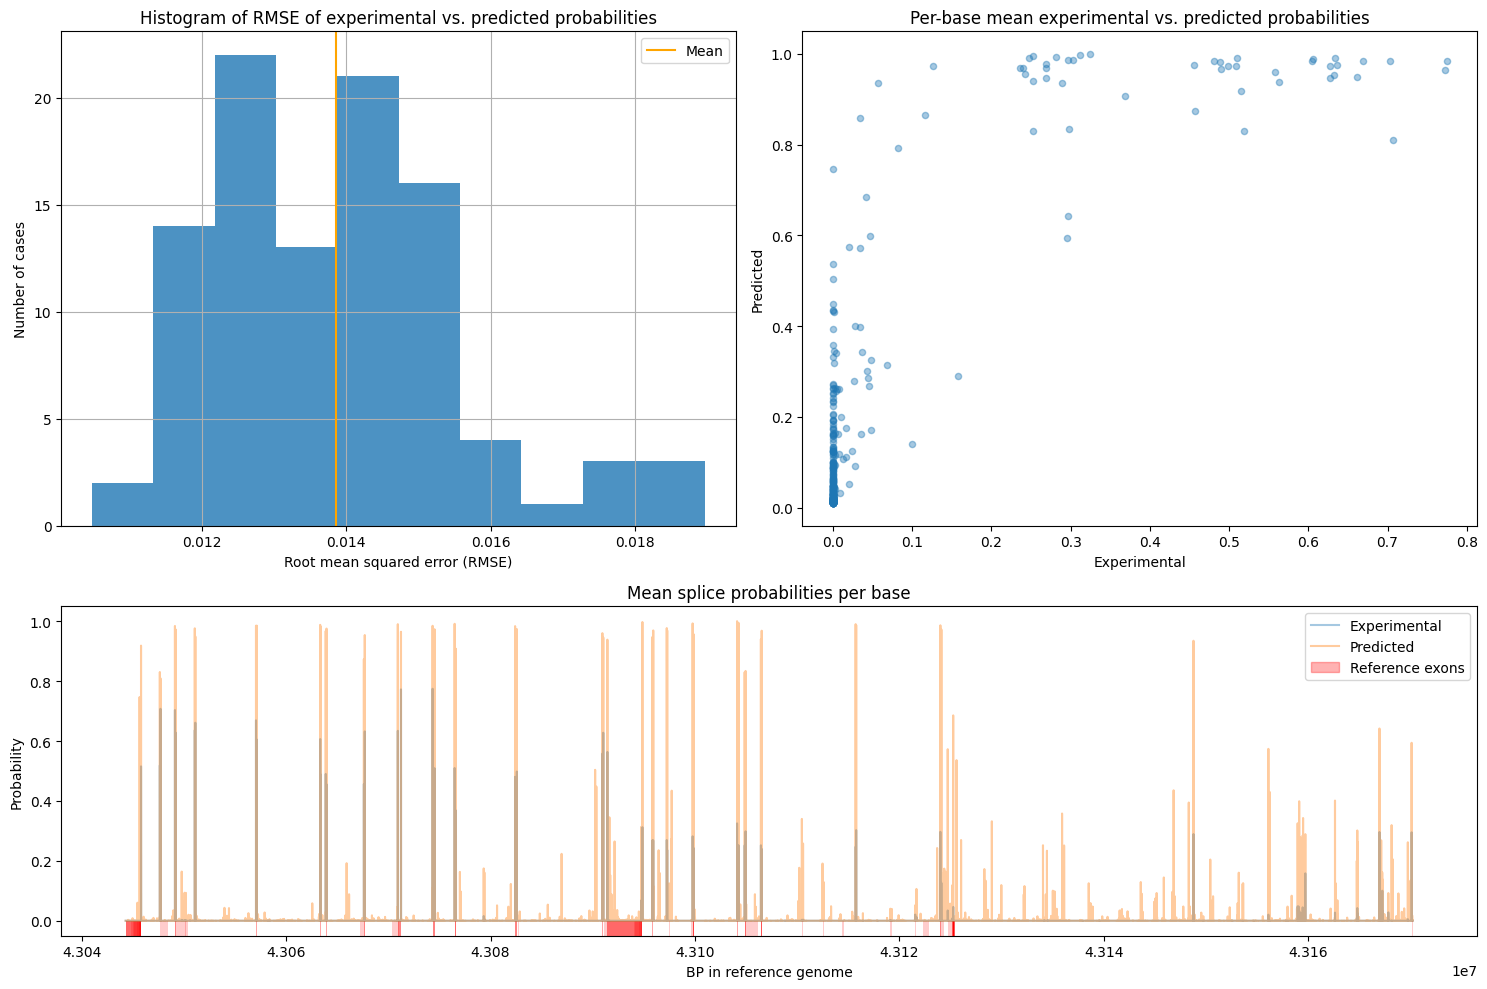

In [13]:
# In-Notebook overview
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2,2, height_ratios=[3, 2])
plot_rmse(fig.add_subplot(gs[0, 0]))
plot_scatter(fig.add_subplot(gs[0, 1]))
plot_pb(fig.add_subplot(gs[1, :]))

plt.tight_layout()
fig_name = f'{predictor.name()}.{variants}'
savefig_pdf(fig_name)
plt.show()

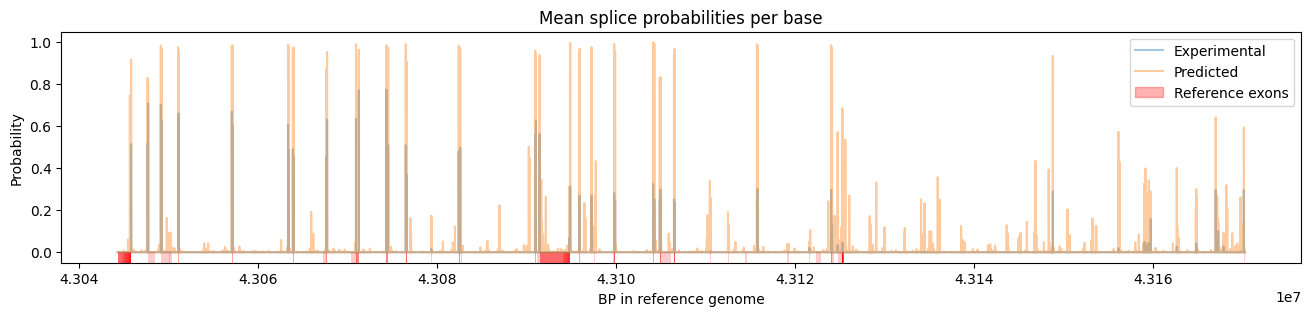

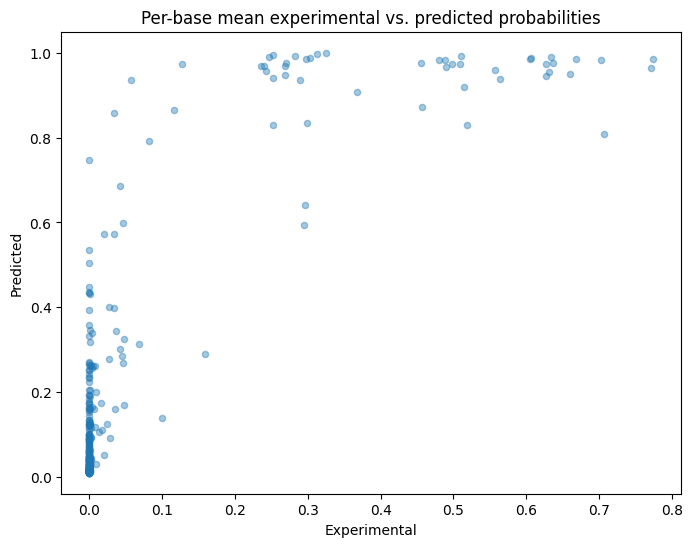

In [14]:
# save individual figures
plt.figure(figsize=(16, 3))
plot_pb(plt.gca())
savefig_pdf(fig_name + '.pb')

plt.figure(figsize=(8, 6))
plot_scatter(plt.gca())
savefig_pdf(fig_name + '.scatter')

plt.show()

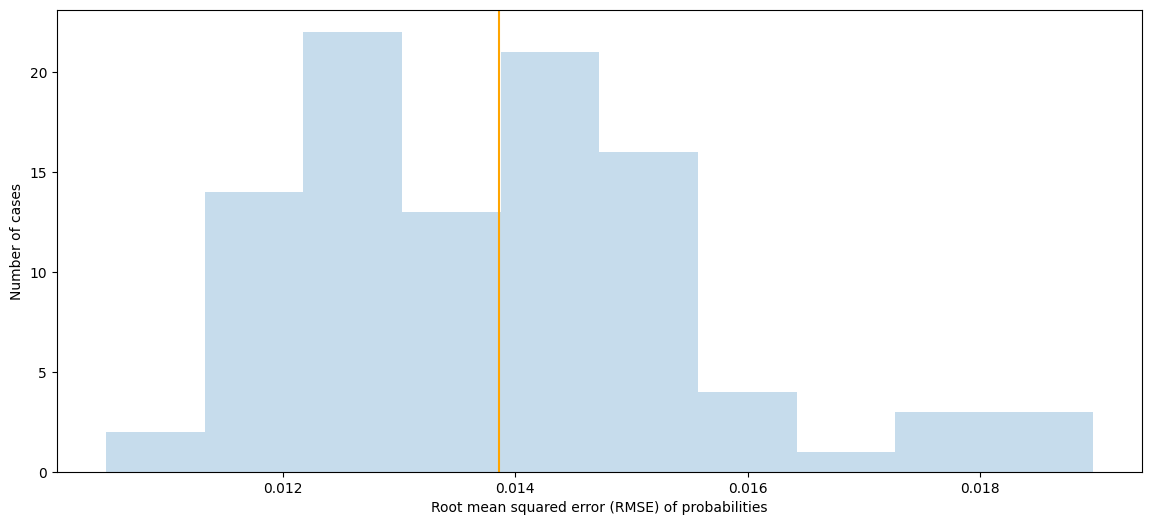

In [15]:
plt.figure(figsize=(14,6))
ax = plt.gca()
# plt.hist(rmses_spliceai, alpha=0.25)
# ax.axvline(x=rmses_spliceai.mean(), color='cornflowerblue')
plt.hist(rmses, alpha=0.25)
ax.axvline(x=rmses.mean(), color='orange')
# plt.legend(['SpliceAI', 'Pangolin'])
ax.set_xlabel('Root mean squared error (RMSE) of probabilities')
ax.set_ylabel('Number of cases')
savefig_pdf('rsmes.pdf')
plt.show()